In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Oct 25 05:32:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    46W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!unzip 'drive/MyDrive/COMP3710/OASIS.zip' -d 'sample_data/data/'

In [ ]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,SubsetRandomSampler
from torchvision import datasets, transforms
from torchsummary import summary
import pickle as pkl
from tqdm import tqdm
from torch.autograd import grad
from torchvision.utils import save_image

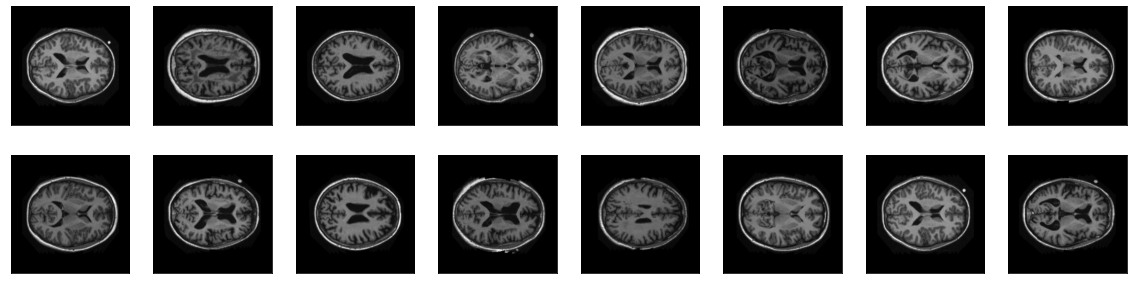

In [ ]:
def Gshow(img): #show gray scale images
  img_=img.cpu()
  img_=img_.numpy()
  img_=img_.reshape(img_.shape[1],img_.shape[2]) #reshape from 64*64*1 to 64*64 as imshow(cmap='gray) only takes two values
  plt.imshow(img_,cmap='gray')# 256*256
dataloader=DataLoader(dataset,num_workers=0,batch_size=b_size,shuffle=True)
dataiter=iter(dataloader)
images,labels=dataiter.next()
plot_only=16 #plot only 16 images
fig=plt.figure(1,figsize=(20,5))
for idx in range(plot_only):
  ax=fig.add_subplot(2,plot_only/2,idx+1,xticks=[],yticks=[])
  Gshow(images[idx])

In [ ]:
"""
learned from:
https://github.com/lernapparat/lernapparat/blob/master/style_gan/pytorch_style_gan_test_discriminator.ipynb
https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/StyleGAN/model.py
https://github.com/facebookresearch/pytorch_GAN_zoo/tree/b75dee40918caabb4fe7ec561522717bf096a8cb/models/networks
"""

In [ ]:
class WScaledConv(nn.Module): #output shape tested
  """
  Weight scaled conv2d,
  input: b *in_features *H *W
  output: b *out_features *H *W (weight scaled)
  """
  def __init__(self, ins, outs, k_size=3, stride=1, padding=1):
    #super(WScaledConv, self).__init__()
    super().__init__()
    self.k_size = k_size
    self.stride = stride
    self.padding = padding

    #gain is usually set to 2**0.5 as default
    self.scale = (2/(k_size*k_size*ins))**(1/2)
    self.w = torch.nn.Parameter(torch.randn(outs, ins, k_size, k_size))
    self.bias = torch.nn.Parameter(torch.zeros(outs))
  def forward(self, x):
    return F.conv2d(x, self.w*self.scale, self.bias, stride=self.stride, padding=self.padding)

In [ ]:
class WScaledLinear(nn.Module): #output shape tested
  """
  Weight scaled Linear,
  input: b *in_channels *H *W
  output: b *out_channels *H *W (weight scaled)
  """
  def __init__(self, ins=512, outs=512, lr_mul=1.0):
    #super(WScaledLinear, self).__init__()
    super().__init__()
    self.ins=ins
    self.outs=outs
    self.lr_mul=lr_mul

    self.scale=((2/ins)**(1/2))*self.lr_mul
    self.w=torch.nn.Parameter(torch.randn(outs, ins))
    self.bias=torch.nn.Parameter(torch.zeros(outs))
  def forward(self, x):
    return F.linear(x, self.w*self.scale, self.bias)

In [ ]:
class PixelNorm(nn.Module): #embedding into MappingNet, not used anymore
  """
  Pixel normalization,
  input: b *z_dimension
  output: b *z_dimension (normalized)
  """
  def __init__(self, epsilon=1e-8):
    #super(PixelNorm, self).__init__()
    super().__init__()
    self.epsilon=epsilon
  def forward(self, x):
    #normalize by avearage value across dimension 1 plus epsilon
    x_=(x*x).mean(dim=1,keepdim=True)+self.epsilon
    return x/(x_**0.5)

In [ ]:
class MappingNet(nn.Module): #output shape tested
  """
  8-dense-layers MappingNet, projecting latent z(ins) to w(outs)
  PixelNorm is merged into here
  input: b *z_dimension
  output: b *w_dimension
  """
  def __init__(self,ins=512,outs=512,n_layers=8):
    super().__init__()
    self.mapping=nn.ModuleList()
    #self.mapping.append(PixelNorm())
    self.mapping.append(WScaledLinear(ins,outs,lr_mul=0.01))
    for i in range(n_layers-1):
      self.mapping.append(nn.ReLU())
      self.mapping.append(WScaledLinear(outs,outs,lr_mul=0.01))
  def forward(self, x):
    #PixelNorm
    x_=(x*x).mean(dim=1,keepdim=True)+1e-8 #epsilon=1e-8
    x=x/(x_**0.5)
    #8 dense layers
    for model in self.mapping:
      x=model(x)
    return x

In [ ]:
class AdaIN(nn.Module): #output shape tested
  """
  Adaptive Instance Norm,
  latent w required for using "style", use WScaledLinear(ins(w), outs(c))
  where w is the #-output of the mapping net and c is the #-output channels of the previous layer
  input: w, b *w_dim, and x, b *in_features *H *W
  output: x, b *out_features *H *W (multiplied by and added with style)
  """
  def __init__(self, ins=512, outs=512): 
    #super(AdaIN, self).__init__()
    super().__init__()
    self.insnorm=nn.InstanceNorm2d(outs,affine=False)# facebookresearch uses eps=1e-08
    self.style_wfactor=WScaledLinear(ins,outs)
    self.style_bias=WScaledLinear(ins,outs)
  def forward(self, x, w):
    #latent w is the output of the mapping net
    #x is the output of the previous layer
    size=x.size()
    style_wf=self.style_wfactor(w).view(size[0],size[1],1,1)
    style_b=self.style_bias(w).view(size[0],size[1],1,1)
    return x*style_wf+style_b


In [ ]:
class Gblock(nn.Module): #output shape tested
  """
  Generative block,
  each block contains one upscale layer and two conv layers (except for the initial block)
  input: w, b *w_dim, and x, b *in_features *H *W
  output: x, b *out_features *H *W 
  """
  def __init__(self, initial=False, ins=512, outs=512, b_size=32):
    #super(Gblock, self).__init__()
    super().__init__()
    self.initial=initial
    self.ins=ins
    self.outs=outs
    self.b_size=b_size
    
    if self.initial:
      self.const=nn.Parameter(torch.ones((b_size,ins,4,4)))
      self.noise_scaler1=((2/(4*4*self.ins))**(1/2))
    else:
      self.conv1=WScaledConv(ins=self.ins,outs=self.outs)
      self.noise_scaler1=((2/(3*3*self.ins))**(1/2))
    self.noise_w1=nn.Parameter(torch.zeros(1, self.outs, 1, 1))###
    self.ada1=AdaIN(outs=outs)

    self.conv2=WScaledConv(ins=self.outs,outs=self.outs)
    self.noise_scaler2=((2/(3*3*self.outs))**(1/2))
    self.noise_w2=nn.Parameter(torch.zeros(1, self.outs, 1, 1))###
    self.ada2=AdaIN(outs=outs)
    self.lkrelu=nn.LeakyReLU(0.2,inplace=True)
  def upscale(self, x):
    return F.interpolate(x,scale_factor=2)#,mode='bilinear') #bilinear?

  def forward(self, x, w):
    if self.initial:
      x=self.const
      #constant
      #or one dense layer for random inputs
    else:
      x=self.upscale(x)#upscale
      x=self.conv1(x)#conv1(WScaled)
      x=self.lkrelu(x)
    size=x.size()
    noise1=torch.randn((size[0], 1, size[2], size[3]),device="cuda")*self.noise_scaler1
    x=x+self.noise_w1*noise1#add noise
    x=self.ada1(x,w)#AdaIn

    x=self.conv2(x)
    x=self.lkrelu(x)
    noise2=torch.randn((size[0], 1, size[2], size[3]),device="cuda")*self.noise_scaler2
    x=x+self.noise_w2*noise2#add noise
    #add noise
    x=self.ada2(x,w)#AdaIn
    return x

In [ ]:
noise=torch.randn(32,512)
mp=MappingNet()
noise=mp(noise)
Gblk1=Gblock(initial=True)
Gblk2=Gblock(ins=512,outs=256)
Gblk3=Gblock(ins=256,outs=128)
Gblk4=Gblock(ins=128,outs=64)
Gblk5=Gblock(ins=64,outs=32)
Gblk6=Gblock(ins=32,outs=16)
Gblk7=Gblock(ins=16,outs=8)
a=Gblk1(x=None,w=noise)
print(a.shape)
b=Gblk2(x=a,w=noise)
print(b.shape)
c=Gblk3(x=b,w=noise)
print(c.shape)
d=Gblk4(x=c,w=noise)
print(d.shape)
e=Gblk5(x=d,w=noise)
print(e.shape)
f=Gblk6(x=e,w=noise)
print(f.shape)
g=Gblk7(x=f,w=noise)
print(g.shape)

torch.Size([32, 512, 4, 4])
torch.Size([32, 256, 8, 8])
torch.Size([32, 128, 16, 16])
torch.Size([32, 64, 32, 32])
torch.Size([32, 32, 64, 64])
torch.Size([32, 16, 128, 128])
torch.Size([32, 8, 256, 256])


In [ ]:
class Gnet(nn.Module):
  """
  Generator,
  input: noise, b *num_features, 32*512
  output: image, b *num_channels *H *W, 32*1*256*256
  #-blocks = 7 [0 1 2 3 4 5 6]
  #-features= [ 512), 512, 256, 128, 64, 32, 16, 8 ]
  img_size = [ 4const), 4, 8, 16, 32, 64, 128, 256 ]
  """
  def __init__(self, b_size=32, nc=1):
    super().__init__()
    #total #-batches is 354
    n_features=[512, 256, 128, 64, 32, 16, 8]
    self.n_layers=len(n_features)
    self.steps=0
    #self.noise=noise
    self.b_size=b_size

    self.alpha=1.0
    self.cur_sacle=0
    
    self.z2w=MappingNet()
    self.Gblocks=nn.ModuleList()
    self.Gblocks.append(Gblock(initial=True))
    for i in range(self.n_layers-1):
      self.Gblocks.append(Gblock(ins=n_features[i],outs=n_features[i+1]))
    
    self.toImg=nn.ModuleList()
    for i in range(self.n_layers):
      self.toImg.append(WScaledConv(ins=n_features[i],outs=nc,k_size=1,stride=1,padding=0))
    #self.Gblk1=Gblock(initial=True)
    #self.Gblk2=Gblock(ins=512,outs=256)
    #self.Gblk3=Gblock(ins=256,outs=128)
    #self.Gblk4=Gblock(ins=128,outs=64)
    #self.Gblk5=Gblock(ins=64,outs=32)
    #self.Gblk6=Gblock(ins=32,outs=16)
    #self.Gblk7=Gblock(ins=16,outs=8)
  def fadeIn(self, x_cur=None, x_pre=None):
    last=self.toImg[self.steps](x_cur)
    if self.alpha>0:
      Sndlast=self.toImg[self.steps-1](x_pre)
      Sndlast=F.interpolate(Sndlast,scale_factor=2)#,mode='bilinear')
      return self.alpha*Sndlast+(1-self.alpha)*last
    else:
      return last
  def forward(self, noise, alpha, steps):
    self.steps=steps
    self.alpha=alpha
    w=self.z2w(noise)
    if self.steps==0:
      return self.toImg[0](self.Gblocks[0](x=None,w=w))
    else:
      for i in range(0,self.steps+1):
        if i==0:
          x=self.Gblocks[0](x=None,w=w)
        else:
          x=self.Gblocks[i](x,w)

        if i==self.steps-1:
          x_=x      
      return self.fadeIn(x_cur=x, x_pre=x_)

In [ ]:
G=Gnet()
noise=torch.randn(32,512)
a=G(noise,alpha=0.5,steps=6)
a.shape

0 torch.Size([32, 512, 4, 4])
1 torch.Size([32, 256, 8, 8])
2 torch.Size([32, 128, 16, 16])
3 torch.Size([32, 64, 32, 32])
4 torch.Size([32, 32, 64, 64])
5 torch.Size([32, 16, 128, 128])
6 torch.Size([32, 8, 256, 256])


torch.Size([32, 1, 256, 256])

In [ ]:
class Dblock(nn.Module):
  """
  input: b*n_features*H*W
  output: b*(n_features/2)*H*W, for the initial(last) layer is b*1(classification result)
  minibatch_std not implemented yet
  """
  def __init__(self, initial=False, ins=512, outs=512, b_size=32):
    super().__init__()
    self.initial=initial
    self.ins=ins if not initial else ins+1
    self.outs=outs
    self.b_size=b_size

    self.conv1=WScaledConv(self.ins,self.outs,k_size=3)
    if self.initial:
      self.conv2=WScaledConv(self.outs,self.outs,k_size=4,padding=0)
      self.conv3=WScaledConv(self.outs,1,k_size=1,padding=0)
    else:
      self.conv2=WScaledConv(self.outs,self.outs,k_size=3,padding=1)
      self.downscale=nn.AvgPool2d(kernel_size=2,stride=2)
    self.lkrelu=nn.LeakyReLU(0.2,inplace=True)
  def minibatch_std(self, x):
    size=x.size()
    batch_std=torch.std(x,dim=0)
    mean_std=batch_std.mean()
    return torch.cat([x,mean_std.repeat(size[0],1,size[2],size[3])],dim=1)
  def forward(self, x):
    if self.initial:
      x=self.minibatch_std(x)
      
    x=self.lkrelu(self.conv1(x))
    x=self.lkrelu(self.conv2(x))
    if self.initial:
      x=self.conv3(x).view(self.b_size,-1)
    else:
      x=self.downscale(x)
    return x

In [ ]:
n=torch.randn(32,8,256,256)
n_features=[8, 16, 32, 64, 128, 256, 512]
k=nn.ModuleList()
for i in range(7-1):
  k.append(Dblock(ins=n_features[i],outs=n_features[i+1]))
k.append(Dblock(initial=True))
print(n.shape)
for m in k:
  n=m(n)
  print(n.shape)

torch.Size([32, 8, 256, 256])
torch.Size([32, 16, 128, 128])
torch.Size([32, 32, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 128, 16, 16])
torch.Size([32, 256, 8, 8])
torch.Size([32, 512, 4, 4])
torch.Size([32, 1])


In [ ]:
class Dnet(nn.Module): #output shape tested
  """
  Discriminator,
  input: image b*1*H*W
  output: classification result b*1
  """
  def __init__(self, b_size=32, nc=1):
    super().__init__()
    #total #-batches is 354
    n_features=[8, 16, 32, 64, 128, 256, 512]
    self.n_layers=len(n_features)
    self.steps=0
    self.b_size=b_size

    self.alpha=1.0
    self.alpha_decay=2.26e-4
    self.cur_sacle=0
    
    self.Dblocks=nn.ModuleList()
    for i in range(self.n_layers-1):
      self.Dblocks.append(Dblock(ins=n_features[i],outs=n_features[i+1]))
    self.Dblocks.append(Dblock(initial=True))

    self.fromImg=nn.ModuleList()
    for i in range(self.n_layers):
      self.fromImg.append(WScaledConv(ins=nc,outs=n_features[i],k_size=1,stride=1,padding=0))
    #self.Dblk1=Dblock(ins=8,outs=16)    #self.Gblk7=Gblock(ins=16,outs=8)
    #self.Dblk2=Dblock(ins=16,outs=32)   #self.Gblk6=Gblock(ins=32,outs=16)
    #self.Dblk3=Dblock(ins=32,outs=64)   #self.Gblk5=Gblock(ins=64,outs=32)
    #self.Dblk4=Dblock(ins=64,outs=128)   #self.Gblk4=Gblock(ins=128,outs=64)
    #self.Dblk5=Dblock(ins=128,outs=256)  #self.Gblk3=Gblock(ins=256,outs=128)
    #self.Dblk6=Dblock(ins=256,outs=512)  #self.Gblk2=Gblock(ins=512,outs=256)
    #self.Dblk7=Dblock(initial=True)    #self.Gblk1=Gblock(initial=True)
    
  def fadeIn(self, x):
    t=self.n_layers-self.steps-1
    last=self.Dblocks[t](self.fromImg[t](x))
    if self.alpha>0:
      Sndlast=self.fromImg[t+1](nn.AvgPool2d(kernel_size=2,stride=2)(x))
      return self.alpha*Sndlast+(1-self.alpha)*last
    else:
      return last

  def forward(self, x, alpha, steps):
    self.steps=steps
    self.alpha=alpha
    if self.steps==0:
      return self.Dblocks[-1](self.fromImg[-1](x))
    else:
      t=self.n_layers-self.steps-1
      x=self.fadeIn(x)
      for i in range(t+1,self.n_layers):
        x=self.Dblocks[i](x)
      return x

In [ ]:
n=torch.randn(32,1,256,256)
a=Dnet()
t=a(n,0.5,6)
print(t.shape)

In [ ]:
class Trainer():
  def __init__(self, b_size=32, z_dim=512, nc=1, dataroot=f'sample_data/data',sample_path='drive/MyDrive/training_results_style/', device='cuda', prog_epochs=[20,20,25,35,40,45,50]
            ):
    self.b_size=b_size
    self.z_dim=z_dim
    self.nc=nc
    self.dataroot=dataroot
    self.sample_path=sample_path
    self.model_path=sample_path#
    self.device=device
    self.prog_epochs=prog_epochs
    
    self.cur_epoch=0
    self.img_size=4
    self.dataset_length=None
    self.dataloader=None
    self.step=0
    self.alpha=0.999

    self.fixed_noise1,self.fixed_noise2=torch.randn((self.b_size, self.z_dim)).to(device),torch.randn((self.b_size, self.z_dim)).to(device)    
    self.lr=0.001
    self.G,self.D=Gnet().to(self.device),Dnet().to(self.device)
    self.scaler_G,self.scaler_D=torch.cuda.amp.GradScaler(),torch.cuda.amp.GradScaler()
    self.opt_G = optim.Adam([{"params": [param for name, param in self.G.named_parameters() if "map" in name],"lr":self.lr*0.01},
                {"params": [param for name, param in self.G.named_parameters() if "map" not in name],"lr":self.lr}], betas=(0.0, 0.99))
    self.opt_D = optim.Adam(self.D.parameters(), lr=self.lr, betas=(0.0, 0.99))

  def get_loader(self):
    transform = transforms.Compose([transforms.Resize((self.img_size, self.img_size)), transforms.ToTensor(),
                    transforms.Grayscale(1), transforms.Normalize(0.5,0.5)])
    dataset = datasets.ImageFolder(root=self.dataroot, transform=transform)
    self.dataloader = DataLoader(dataset, batch_size=self.b_size,
            shuffle=True, num_workers=0, pin_memory=True)
    self.dataset_length=len(dataset)
  def train_D(self,real):
    noise = torch.randn(self.b_size, self.z_dim).to(self.device)
    self.opt_D.zero_grad()
    with torch.cuda.amp.autocast():
      fake = self.G(noise, self.alpha, self.step)###fake1 and fake2
      D_real = self.D(real, self.alpha, self.step)
      D_fake = self.D(fake.detach(), self.alpha, self.step)
      loss_D1=F.softplus(D_fake)
      loss_D2=F.softplus(-D_real)
      loss_Dall=torch.mean(loss_D1+loss_D2)
      
    self.scaler_D.scale(loss_Dall).backward()
    self.scaler_D.step(self.opt_D)
    self.scaler_D.update()
  def train_G(self):
    noise = torch.randn(self.b_size, self.z_dim).to(self.device)
    self.opt_G.zero_grad()       
    with torch.cuda.amp.autocast():
      fake = self.G(noise, self.alpha, self.step)
      D_fake = self.D(fake, self.alpha, self.step)       
      loss_G=torch.mean(F.softplus(-D_fake))
    self.scaler_G.scale(loss_G).backward()
    self.scaler_G.step(self.opt_G)
    self.scaler_G.update()
  def train_one_epoch(self):
    iterations=tqdm(self.dataloader)
    samples_save=[]
    for i, [real, _] in enumerate(iterations):
      real = real.to(self.device)
      #Train D
      self.train_D(real)
      #Train G     
      self.train_G()
      #Update alpha and ensure greater than 0
      self.alpha -= self.b_size/((self.prog_epochs[self.step]*0.5)*self.dataset_length)
      self.alpha = max(self.alpha,0)

  def save_samples(self):
    with torch.no_grad():
      fixed_fakes=(self.G(self.fixed_noise1, self.alpha, self.step)/2)+0.5
      fixed_fakes=torch.clamp(fixed_fakes,min=0.0,max=1.0)
      samples_save=[fixed_fakes]
      with open(self.sample_path+'train_samples_'+str(self.step)+'_'+str(self.cur_epoch)+'.pkl', 'wb') as f:
        pkl.dump(samples_save, f)
      print('Min',torch.min(fixed_fakes[0]).item(),'Mean',torch.mean(fixed_fakes[0]).item(),'Max',torch.max(fixed_fakes[0]).item())

  def save_model(self):
    save_G={"state_dict":self.G.state_dict(),"optimizer":self.opt_G.state_dict()}
    torch.save(save_G,self.model_path+'G.pth')
    save_D={"state_dict":self.D.state_dict(),"optimizer":self.opt_D.state_dict()}
    torch.save(save_D,self.model_path+'D.pth')
    
  def update_para(self):
    self.step+=1
    self.img_size=2**(self.step+2)
    self.alpha=0.999
  def training_loop(self):
    self.G.train()
    self.D.train()
    for n_epochs in self.prog_epochs[self.step:]:
      print("Current img size:", self.img_size)
      self.get_loader()
      for epoch in range(n_epochs):
        self.cur_epoch=epoch+1
        print("Epoch: [",epoch+1,"/",n_epochs,"]")
        self.train_one_epoch()
        self.save_samples()

      self.update_para()
    self.save_model()

In [ ]:
t=Trainer(prog_epochs=[10,10,10,10,10,15,15])
t.training_loop()

Current img size: 4
Epoch: [ 1 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 14.84it/s]


Max 0.0 Mean 0.09070317447185516 Min 0.2555307149887085
Epoch: [ 2 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 14.78it/s]


Max 0.0 Mean 0.14167238771915436 Min 0.32454946637153625
Epoch: [ 3 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 14.81it/s]


Max 0.030382871627807617 Mean 0.13367518782615662 Min 0.2723768949508667
Epoch: [ 4 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 14.83it/s]


Max 0.03855571150779724 Mean 0.15969577431678772 Min 0.30348074436187744
Epoch: [ 5 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 14.82it/s]


Max 0.046970903873443604 Mean 0.1729268729686737 Min 0.312132328748703
Epoch: [ 6 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 15.04it/s]


Max 0.039987802505493164 Mean 0.17573559284210205 Min 0.3208390474319458
Epoch: [ 7 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 14.78it/s]


Max 0.017019569873809814 Mean 0.144638329744339 Min 0.2810118794441223
Epoch: [ 8 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 14.76it/s]


Max 0.003598839044570923 Mean 0.12696655094623566 Min 0.26191097497940063
Epoch: [ 9 / 10 ]


100%|██████████| 354/354 [00:24<00:00, 14.72it/s]


Max 0.0 Mean 0.11804790049791336 Min 0.24268576502799988
Epoch: [ 10 / 10 ]


100%|██████████| 354/354 [00:23<00:00, 14.79it/s]


Max 0.009092748165130615 Mean 0.1290796846151352 Min 0.2679975628852844
Current img size: 8
Epoch: [ 1 / 10 ]


100%|██████████| 354/354 [00:28<00:00, 12.28it/s]


Max 0.0 Mean 0.17323142290115356 Min 0.4238322377204895
Epoch: [ 2 / 10 ]


100%|██████████| 354/354 [00:28<00:00, 12.32it/s]


Max 0.0 Mean 0.16961675882339478 Min 0.40526247024536133
Epoch: [ 3 / 10 ]


100%|██████████| 354/354 [00:28<00:00, 12.36it/s]


Max 0.0 Mean 0.13986273109912872 Min 0.35485535860061646
Epoch: [ 4 / 10 ]


100%|██████████| 354/354 [00:28<00:00, 12.44it/s]


Max 0.0 Mean 0.1571907103061676 Min 0.39321020245552063
Epoch: [ 5 / 10 ]


100%|██████████| 354/354 [00:28<00:00, 12.30it/s]


Max 0.0 Mean 0.14724205434322357 Min 0.35853487253189087
Epoch: [ 6 / 10 ]


100%|██████████| 354/354 [00:27<00:00, 12.77it/s]


Max 0.0 Mean 0.13200372457504272 Min 0.3442564308643341
Epoch: [ 7 / 10 ]


100%|██████████| 354/354 [00:27<00:00, 12.73it/s]


Max 0.0 Mean 0.12729236483573914 Min 0.32610267400741577
Epoch: [ 8 / 10 ]


100%|██████████| 354/354 [00:27<00:00, 12.77it/s]


Max 0.0 Mean 0.14697304368019104 Min 0.3403722643852234
Epoch: [ 9 / 10 ]


100%|██████████| 354/354 [00:27<00:00, 12.79it/s]


Max 0.0 Mean 0.11645437777042389 Min 0.3234354853630066
Epoch: [ 10 / 10 ]


100%|██████████| 354/354 [00:27<00:00, 12.83it/s]


Max 0.0 Mean 0.13702642917633057 Min 0.32052868604660034
Current img size: 16
Epoch: [ 1 / 10 ]


100%|██████████| 354/354 [00:33<00:00, 10.67it/s]


Max 0.003093928098678589 Mean 0.15926218032836914 Min 0.3907085061073303
Epoch: [ 2 / 10 ]


100%|██████████| 354/354 [00:33<00:00, 10.63it/s]


Max 0.0 Mean 0.16553671658039093 Min 0.4166443645954132
Epoch: [ 3 / 10 ]


100%|██████████| 354/354 [00:33<00:00, 10.63it/s]


Max 0.0 Mean 0.12662576138973236 Min 0.34105634689331055
Epoch: [ 4 / 10 ]


100%|██████████| 354/354 [00:33<00:00, 10.64it/s]


Max 0.0 Mean 0.12273144721984863 Min 0.46742331981658936
Epoch: [ 5 / 10 ]


100%|██████████| 354/354 [00:33<00:00, 10.66it/s]


Max 0.00955471396446228 Mean 0.15790703892707825 Min 0.47433117032051086
Epoch: [ 6 / 10 ]


100%|██████████| 354/354 [00:32<00:00, 11.01it/s]


Max 0.0 Mean 0.13915516436100006 Min 0.46916449069976807
Epoch: [ 7 / 10 ]


100%|██████████| 354/354 [00:32<00:00, 10.96it/s]


Max 0.0 Mean 0.14904139935970306 Min 0.4974266290664673
Epoch: [ 8 / 10 ]


100%|██████████| 354/354 [00:32<00:00, 10.96it/s]


Max 0.0 Mean 0.12228427827358246 Min 0.4401547610759735
Epoch: [ 9 / 10 ]


100%|██████████| 354/354 [00:32<00:00, 10.97it/s]


Max 0.0 Mean 0.12465840578079224 Min 0.4320158362388611
Epoch: [ 10 / 10 ]


100%|██████████| 354/354 [00:32<00:00, 10.93it/s]


Max 0.0 Mean 0.1107812151312828 Min 0.4051465392112732
Current img size: 32
Epoch: [ 1 / 10 ]


100%|██████████| 354/354 [00:37<00:00,  9.43it/s]


Max 0.00484013557434082 Mean 0.1426764279603958 Min 0.4532133936882019
Epoch: [ 2 / 10 ]


100%|██████████| 354/354 [00:37<00:00,  9.52it/s]


Max 0.0 Mean 0.11003607511520386 Min 0.4960712194442749
Epoch: [ 3 / 10 ]


100%|██████████| 354/354 [00:37<00:00,  9.48it/s]


Max 0.0 Mean 0.1053101196885109 Min 0.4548281133174896
Epoch: [ 4 / 10 ]


100%|██████████| 354/354 [00:37<00:00,  9.47it/s]


Max 0.0 Mean 0.12738840281963348 Min 0.5275086760520935
Epoch: [ 5 / 10 ]


100%|██████████| 354/354 [00:37<00:00,  9.49it/s]


Max 0.0 Mean 0.1194159984588623 Min 0.5267871022224426
Epoch: [ 6 / 10 ]


100%|██████████| 354/354 [00:36<00:00,  9.71it/s]


Max 0.0 Mean 0.1362721025943756 Min 0.5214463472366333
Epoch: [ 7 / 10 ]


100%|██████████| 354/354 [00:36<00:00,  9.73it/s]


Max 0.0 Mean 0.11834170669317245 Min 0.49493613839149475
Epoch: [ 8 / 10 ]


100%|██████████| 354/354 [00:36<00:00,  9.73it/s]


Max 0.0 Mean 0.08985733985900879 Min 0.4307522773742676
Epoch: [ 9 / 10 ]


100%|██████████| 354/354 [00:36<00:00,  9.67it/s]


Max 0.0 Mean 0.11177080869674683 Min 0.46141648292541504
Epoch: [ 10 / 10 ]


100%|██████████| 354/354 [00:36<00:00,  9.69it/s]


Max 0.0 Mean 0.11042454093694687 Min 0.5147437453269958
Current img size: 64
Epoch: [ 1 / 10 ]


100%|██████████| 354/354 [00:43<00:00,  8.14it/s]


Max 0.0 Mean 0.08907073736190796 Min 0.5778111815452576
Epoch: [ 2 / 10 ]


100%|██████████| 354/354 [00:43<00:00,  8.21it/s]


Max 0.0 Mean 0.1105424091219902 Min 0.7409886121749878
Epoch: [ 3 / 10 ]


100%|██████████| 354/354 [00:43<00:00,  8.19it/s]


Max 0.0 Mean 0.11922890692949295 Min 0.6778931617736816
Epoch: [ 4 / 10 ]


100%|██████████| 354/354 [00:43<00:00,  8.18it/s]


Max 0.0 Mean 0.11225321888923645 Min 0.6477257609367371
Epoch: [ 5 / 10 ]


100%|██████████| 354/354 [00:43<00:00,  8.18it/s]


Max 0.0 Mean 0.11450357735157013 Min 0.7093324065208435
Epoch: [ 6 / 10 ]


100%|██████████| 354/354 [00:42<00:00,  8.32it/s]


Max 0.0 Mean 0.1183449774980545 Min 0.8316540718078613
Epoch: [ 7 / 10 ]


100%|██████████| 354/354 [00:42<00:00,  8.37it/s]


Max 0.0 Mean 0.1071302741765976 Min 0.6731963157653809
Epoch: [ 8 / 10 ]


100%|██████████| 354/354 [00:42<00:00,  8.31it/s]


Max 0.0 Mean 0.13725173473358154 Min 0.7938134074211121
Epoch: [ 9 / 10 ]


100%|██████████| 354/354 [00:42<00:00,  8.30it/s]


Max 0.0 Mean 0.11425810307264328 Min 0.6862629652023315
Epoch: [ 10 / 10 ]


100%|██████████| 354/354 [00:42<00:00,  8.30it/s]


Max 0.0 Mean 0.11383114010095596 Min 0.7741130590438843
Current img size: 128
Epoch: [ 1 / 15 ]


100%|██████████| 354/354 [00:51<00:00,  6.84it/s]


Max 0.0 Mean 0.12268522381782532 Min 0.8097527623176575
Epoch: [ 2 / 15 ]


100%|██████████| 354/354 [00:51<00:00,  6.86it/s]


Max 0.0 Mean 0.12243688106536865 Min 0.7478656768798828
Epoch: [ 3 / 15 ]


100%|██████████| 354/354 [00:51<00:00,  6.84it/s]


Max 0.0 Mean 0.12852312624454498 Min 0.8909889459609985
Epoch: [ 4 / 15 ]


100%|██████████| 354/354 [00:51<00:00,  6.83it/s]


Max 0.0 Mean 0.11798276752233505 Min 0.861808180809021
Epoch: [ 5 / 15 ]


100%|██████████| 354/354 [00:51<00:00,  6.86it/s]


Max 0.0 Mean 0.1263073831796646 Min 0.8474767208099365
Epoch: [ 6 / 15 ]


100%|██████████| 354/354 [00:51<00:00,  6.83it/s]


Max 0.0 Mean 0.12439728528261185 Min 0.9844962358474731
Epoch: [ 7 / 15 ]


100%|██████████| 354/354 [00:51<00:00,  6.84it/s]


Max 0.0 Mean 0.11027073115110397 Min 0.9068927764892578
Epoch: [ 8 / 15 ]


100%|██████████| 354/354 [00:51<00:00,  6.89it/s]


Max 0.0 Mean 0.12262561917304993 Min 1.0
Epoch: [ 9 / 15 ]


100%|██████████| 354/354 [00:50<00:00,  6.98it/s]


Max 0.0 Mean 0.14985021948814392 Min 1.0
Epoch: [ 10 / 15 ]


100%|██████████| 354/354 [00:50<00:00,  6.96it/s]


Max 0.0 Mean 0.1258838176727295 Min 0.8402608036994934
Epoch: [ 11 / 15 ]


100%|██████████| 354/354 [00:50<00:00,  6.97it/s]


Max 0.0 Mean 0.13188748061656952 Min 0.8789055943489075
Epoch: [ 12 / 15 ]


100%|██████████| 354/354 [00:50<00:00,  6.95it/s]


Max 0.0 Mean 0.12961435317993164 Min 0.83678138256073
Epoch: [ 13 / 15 ]


100%|██████████| 354/354 [00:50<00:00,  6.97it/s]


Max 0.0 Mean 0.1160280853509903 Min 0.9054352045059204
Epoch: [ 14 / 15 ]


100%|██████████| 354/354 [00:50<00:00,  6.95it/s]


Max 0.0 Mean 0.12527725100517273 Min 0.7518443465232849
Epoch: [ 15 / 15 ]


100%|██████████| 354/354 [00:50<00:00,  6.96it/s]


Max 0.0 Mean 0.12318789213895798 Min 0.9320054650306702
Current img size: 256
Epoch: [ 1 / 15 ]


100%|██████████| 354/354 [01:06<00:00,  5.32it/s]


Max 0.0 Mean 0.1225580945611 Min 1.0
Epoch: [ 2 / 15 ]


100%|██████████| 354/354 [01:06<00:00,  5.33it/s]


Max 0.0 Mean 0.10190573334693909 Min 0.9815905094146729
Epoch: [ 3 / 15 ]


100%|██████████| 354/354 [01:06<00:00,  5.33it/s]


Max 0.0 Mean 0.10861222445964813 Min 1.0
Epoch: [ 4 / 15 ]


100%|██████████| 354/354 [01:06<00:00,  5.32it/s]


Max 0.0 Mean 0.16124069690704346 Min 1.0
Epoch: [ 5 / 15 ]


100%|██████████| 354/354 [01:06<00:00,  5.32it/s]


Max 0.0 Mean 0.11979486048221588 Min 1.0
Epoch: [ 6 / 15 ]


100%|██████████| 354/354 [01:06<00:00,  5.32it/s]


Max 0.0 Mean 0.11033566296100616 Min 1.0
Epoch: [ 7 / 15 ]


100%|██████████| 354/354 [01:06<00:00,  5.33it/s]


Max 0.0 Mean 0.11058950424194336 Min 1.0
Epoch: [ 8 / 15 ]


100%|██████████| 354/354 [01:06<00:00,  5.35it/s]


Max 0.0 Mean 0.12817278504371643 Min 1.0
Epoch: [ 9 / 15 ]


100%|██████████| 354/354 [01:05<00:00,  5.39it/s]


Max 0.0 Mean 0.12162792682647705 Min 1.0
Epoch: [ 10 / 15 ]


100%|██████████| 354/354 [01:05<00:00,  5.41it/s]


Max 0.0 Mean 0.0975494533777237 Min 1.0
Epoch: [ 11 / 15 ]


100%|██████████| 354/354 [01:05<00:00,  5.40it/s]


Max 0.0 Mean 0.10152944922447205 Min 1.0
Epoch: [ 12 / 15 ]


100%|██████████| 354/354 [01:05<00:00,  5.41it/s]


Max 0.0 Mean 0.1115792840719223 Min 0.9398057460784912
Epoch: [ 13 / 15 ]


100%|██████████| 354/354 [01:05<00:00,  5.40it/s]


Max 0.0 Mean 0.12009310722351074 Min 1.0
Epoch: [ 14 / 15 ]


100%|██████████| 354/354 [01:05<00:00,  5.39it/s]


Max 0.0 Mean 0.12470827251672745 Min 1.0
Epoch: [ 15 / 15 ]


100%|██████████| 354/354 [01:05<00:00,  5.40it/s]


Max 0.0 Mean 0.10753117501735687 Min 1.0
